In [6]:
pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install imbalanced-learn


  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
pip install lightgbm


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [28]:
df = pd.read_csv("diabetes (1).csv")

In [29]:
print(df.head())
print(df.info())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

In [30]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [31]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df[columns_with_zeros] = imputer.fit_transform(df[columns_with_zeros])

In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = iso_forest.fit_predict(df.drop(columns=['Outcome']))
df = df[outlier_predictions == 1]  

In [ ]:
df['Age_BMI'] = df['Age'] * df['BMI']  
df['Glucose_Insulin'] = df['Glucose'] * df['Insulin'] 
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 40, 60, 80], labels=[0, 1, 2]) 

In [35]:
df = pd.get_dummies(df, columns=['Age_Group'], drop_first=True)


In [36]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [37]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]}

In [42]:
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [43]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

In [47]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb, param_grid=xgb_params, cv=5, n_jobs=-1, verbose=2)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\User\OneDrive\Desktop\Tariq\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [48]:
lgb_params = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'boosting_type': ['gbdt']
}

lgb = LGBMClassifier(random_state=42)
lgb_grid = GridSearchCV(lgb, param_grid=lgb_params, cv=5, n_jobs=-1, verbose=2)
lgb_grid.fit(X_train, y_train)
best_lgb = lgb_grid.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 388, number of negative: 388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17184
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [49]:
voting_clf = VotingClassifier(
    estimators=[('RandomForest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgb)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

c:\Users\User\OneDrive\Desktop\Tariq\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 388, number of negative: 388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17184
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\User\OneDrive\Desktop\Tariq\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Ensemble Model Accuracy: 0.8402
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        97
           1       0.84      0.85      0.84        97

    accuracy                           0.84       194
   macro avg       0.84      0.84      0.84       194
weighted avg       0.84      0.84      0.84       194



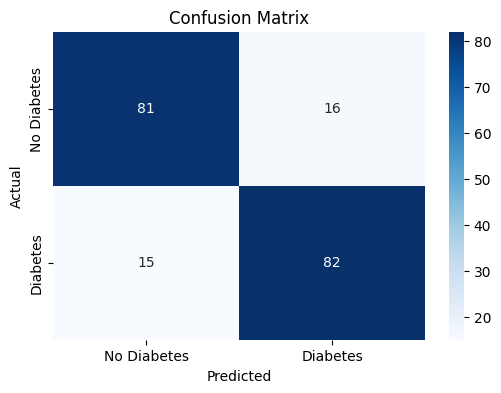

In [52]:


accuracy = accuracy_score(y_test, y_pred)
print(f"\nEnsemble Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
